# Targeting with Partial Incentives

Diffusion of influence in social networks is a widely studied phenomenon in contexts that vary from viral marketing to
the broader field of social sciences.

A problem related to this phenomenon, known as the Target Set Selection, is the one to find the minimum set of nodes to
influence in order to cause a cascade in the network, i.e. the minimum number of individuals to influence directly in
order to have the whole network influenced indirectly.

A variant of this problem is the one in which individuals can be given relatively small incentives to make a decision
rather than requiring the full effort needed to actually influence them. This is the Partial Incentives variant and here
the goal is to find incentives assignment that minimizes the total cost of influencing the whole network.

Both of the above problems have already been studied. This project is an attempt to apply and compare two algorithms
known for solving the variant with partial incentives of the problem in a nondeterministic network using the
deferred decision principle, which considers edges of the network to be active or inactive based on some probability.

## Project structure

A few utility modules have been created in [sources](/src) folder to easily interact with the data. Pre-processing
tasks, that consist of binding thresholds to nodes and edges as well as randomly remove some of the latter by coin
tossing, have been modeled in the [preprocessing](/src/preprocessing) module.

The two algorithms used for the test are implemented in the [targeting](/src/targeting) module. The ones picked are
[DiscountFrac](https://arxiv.org/abs/1401.7970) by Demaine et al. and [TPI](https://arxiv.org/abs/1611.08687) by
Cordasco et al.

In [1]:
import matplotlib
import matplotlib.pyplot as pyplot
import numpy
import snap

from src.preprocessing import data_manager
from src.preprocessing import nodes_manager
from src.preprocessing import edges_manager
from src.preprocessing import edge_pruner

from src.targeting import partial_incentives

%matplotlib inline

## Dataset insights

The dataset chosen for the experiment is [email-Eu-core](/src/data/raw) from the
[SNAP Dataset Collection](https://snap.stanford.edu/data/), a directed graph collected from a large European research
institute modeling the exchange of emails between its members.

The dataset is made of about 1 thousand nodes and more than 25 thousands edges. A more in-depth look can be found
below.

In [2]:
DATASET = "email-Eu-core"

graph = data_manager.load_graph(f"{DATASET}.txt")

print("Number of nodes: ", graph.GetNodes())
print("Number of edges: ", graph.GetEdges())

print("Maximum degree: ", graph.GetNI(snap.GetMxDegNId(graph)).GetDeg())

print("Diameter (approximate): ", snap.GetBfsFullDiam(graph, 10))
print("Triangles: ", snap.GetTriads(graph))
print("Clustering coefficient: ", snap.GetClustCf(graph))

Number of nodes:  1005
Number of edges:  25571
Maximum degree:  546
Diameter (approximate):  5
Triangles:  105461
Clustering coefficient:  0.39935496642215423


## Experiments settings

The deferred decision principle is applied by generating 10 different probabilistic graphs for each node threshold-edge
threshold combination.

Node thresholds are set with 3 different approaches: constant, degree-proportional and random. Constants are chosen as
integers between 2 and 10; degree-proportional thresholds are chosen as fractions of the degree of each node, from 0.1
to 0.9 with a 0.1 step; random ones are generated uniformly for each node in the range that goes from 1 to its degree.

Edge thresholds used to apply the deferred decision principle are chosen in 2 different ways: randomly and
degree-proportional. Random thresholds are generated uniformly in the range from 0 to 1 for each edge;
degree-proportional ones are applicable only for directed graphs and their value is the inverse of the in-degree of
the node the edge points to.

Overall we have 3 different approaches to set the threshold of the nodes while 2 are the ways to set it on edges. The
total amount of combinations is then 6 while the number of experiments is 19 × 2 × 10 = 380.

Due to long computation times it's better to generate the graphs, bind the thresholds to the nodes, prune some of the
edges by applying the deferred decision principle and store them to be able to load the results whenever they're needed
for later analysis.

Also, a maximum budget must be defined as the DiscountFrac algorithm uses it to constraint expenses. Using a very large
value, however, leads the algorithm to influence the whole network using only as much as needed of it.

In [3]:
# Components to associate filenames to the graph used to generate them
N_MARKER_CONSTANT = "n-constant-"
N_MARKER_PROPORTIONAL = "n-proportional-"
N_MARKER_RANDOM = "n-random-"

E_MARKER_PROPORTIONAL = "e-proportional-"
E_MARKER_RANDOM = "e-random-"

# Number of samples to average results among
SAMPLES = 10

# Node threshold ranges
CONSTANT_THRESHOLD_MIN = 2
CONSTANT_THRESHOLD_MAX = 10

PROPORTIONAL_THRESHOLD_MIN = 0.1
PROPORTIONAL_THRESHOLD_MAX = 0.9
PROPORTIONAL_THRESHOLD_COUNT = 9

# Maximum budget for algorithms that are bounded on the total expense
MAX_BUDGET = 2147483648

## Results

Results are reported for each node-edge threshold combination, so 6 sections follow.

Each section has 2 code cells, one to generate the data and the other to average out and plot the relative results.

Algorithms performances are plotted in graphs with the total cost computed by each on the y-axis while the x-axis is
used for the thresholds. Results of random nodes thresholds however are reported in tables.

### Constant node thresholds with degree-proportional edge thresholds

Here is the case where node thresholds are set as constants while edges activation thresholds are chosen as proportional
to the degree of the node they point to.

In [4]:
for threshold in range(CONSTANT_THRESHOLD_MIN, CONSTANT_THRESHOLD_MAX + 1):
    for i in range(SAMPLES):
        # Define the file name for the current combination
        name = f"{DATASET} {N_MARKER_CONSTANT}{threshold} {E_MARKER_PROPORTIONAL}{i}"
        
        # Compute nodes and edges thresholds
        node_thresholds = nodes_manager.constant_thresholds(graph, threshold)
        edge_thresholds = edges_manager.degree_proportional_thresholds(graph)
        
        # Prune edges
        probabilistic = edge_pruner.random_prune(graph, edge_thresholds, i)
        
        # Dump the graph generated and its thresholds
        data_manager.store_graph(probabilistic, f"{name}.graph")
        data_manager.store_node_thresholds(node_thresholds, f"{name}.node.thresholds")
        
        # Compute incentive assignment for each node
        tpi_incentives = partial_incentives.tpi(probabilistic, node_thresholds)
        data_manager.store_incentives(tpi_incentives, f"{name}.tpi.incentives")
        
        discount_frac_incentives = partial_incentives.discount_frac(probabilistic, node_thresholds, MAX_BUDGET)
        data_manager.store_incentives(discount_frac_incentives, f"{name}.discount.incentives")

Once the files are saved it's possible to see the results by plotting the average cost obtained for the 10 different
ways the edges of the original graph have been pruned when applying the deferred decision principle.

The total amount spent by each algorithm is plotted on the vertical axis while the constant to which node
thresholds have been set is reported on the horizontal one.

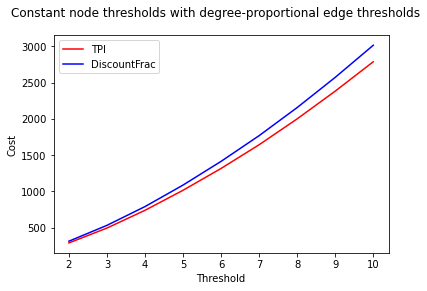

In [5]:
thresholds = range(CONSTANT_THRESHOLD_MIN, CONSTANT_THRESHOLD_MAX + 1)
tpi = numpy.zeros(CONSTANT_THRESHOLD_MAX - CONSTANT_THRESHOLD_MIN + 1)
discount = numpy.zeros(CONSTANT_THRESHOLD_MAX - CONSTANT_THRESHOLD_MIN + 1)

for threshold in thresholds:
    # Track the sum for each threshold
    tpi_total = 0
    discount_total = 0
    
    for i in range(SAMPLES):
        # Define the file name for the current combination
        name = f"{DATASET} {N_MARKER_CONSTANT}{threshold} {E_MARKER_PROPORTIONAL}{i}"
        
        # Load incentives
        tpi_incentives = data_manager.load_incentives(f"{name}.tpi.incentives")
        discount_incentives = data_manager.load_incentives(f"{name}.discount.incentives")
        
        # Compute the total for each algorithm
        tpi_total += sum(tpi_incentives.values())
        discount_total += sum(discount_incentives.values())
    
    # Compute the average
    tpi[threshold - CONSTANT_THRESHOLD_MIN] = tpi_total / SAMPLES
    discount[threshold - CONSTANT_THRESHOLD_MIN] = discount_total / SAMPLES

# Plot the results
figure, axes = pyplot.subplots()

figure.suptitle("Constant node thresholds with degree-proportional edge thresholds")
axes.set_xlabel("Threshold")
axes.set_ylabel("Cost")

axes.plot(thresholds, tpi, "r", label="TPI")
axes.plot(thresholds, discount, "b", label="DiscountFrac")

axes.legend(loc="upper left")

pyplot.show()

Here the performance of the two algorithms is quite similar even though TPI constantly outperforms DiscountFrac. As
expected the total cost increases as the threshold of the nodes is incremented.

### Constant node thresholds with random edge thresholds

In this case where node thresholds are set as constants while edges activation thresholds are chosen randomly between 0
and 1.

In [6]:
for threshold in range(CONSTANT_THRESHOLD_MIN, CONSTANT_THRESHOLD_MAX + 1):
    for i in range(SAMPLES):
        # Define the file name for the current combination
        name = f"{DATASET} {N_MARKER_CONSTANT}{threshold} {E_MARKER_RANDOM}{i}"

        # Compute nodes and edges thresholds
        node_thresholds = nodes_manager.constant_thresholds(graph, threshold)
        edge_thresholds = edges_manager.random_thresholds(graph, i)

        # Prune edges
        probabilistic = edge_pruner.random_prune(graph, edge_thresholds, i)

        # Dump the graph generated and its thresholds
        data_manager.store_graph(probabilistic, f"{name}.graph")
        data_manager.store_node_thresholds(node_thresholds, f"{name}.node.thresholds")

        # Compute incentive assignment for each node
        tpi_incentives = partial_incentives.tpi(probabilistic, node_thresholds)
        data_manager.store_incentives(tpi_incentives, f"{name}.tpi.incentives")

        discount_frac_incentives = partial_incentives.discount_frac(probabilistic, node_thresholds, MAX_BUDGET)
        data_manager.store_incentives(discount_frac_incentives, f"{name}.discount.incentives")

Once again after the files are saved it's possible to have a glimpse at the results by plotting the average cost
obtained for the 10 different ways the edges of the original graph have been pruned when applying the deferred decision
principle.

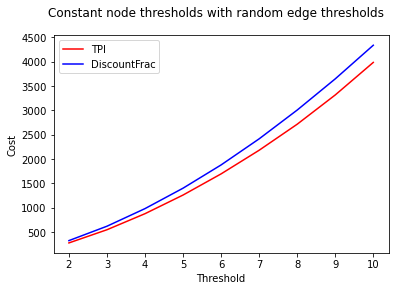

In [7]:
thresholds = range(CONSTANT_THRESHOLD_MIN, CONSTANT_THRESHOLD_MAX + 1)
tpi = numpy.zeros(CONSTANT_THRESHOLD_MAX - CONSTANT_THRESHOLD_MIN + 1)
discount = numpy.zeros(CONSTANT_THRESHOLD_MAX - CONSTANT_THRESHOLD_MIN + 1)

for threshold in thresholds:
    # Track the sum for each threshold
    tpi_total = 0
    discount_total = 0

    for i in range(SAMPLES):
        # Define the file name for the current combination
        name = f"{DATASET} {N_MARKER_CONSTANT}{threshold} {E_MARKER_RANDOM}{i}"

        # Load incentives
        tpi_incentives = data_manager.load_incentives(f"{name}.tpi.incentives")
        discount_incentives = data_manager.load_incentives(f"{name}.discount.incentives")

        # Compute the total for each algorithm
        tpi_total += sum(tpi_incentives.values())
        discount_total += sum(discount_incentives.values())

    # Compute the average
    tpi[threshold - CONSTANT_THRESHOLD_MIN] = tpi_total / SAMPLES
    discount[threshold - CONSTANT_THRESHOLD_MIN] = discount_total / SAMPLES

# Plot the results
figure, axes = pyplot.subplots()

figure.suptitle("Constant node thresholds with random edge thresholds")
axes.set_xlabel("Threshold")
axes.set_ylabel("Cost")

axes.plot(thresholds, tpi, "r", label="TPI")
axes.plot(thresholds, discount, "b", label="DiscountFrac")

axes.legend(loc="upper left")

pyplot.show()

As in the previous case, TPI performs better than DiscountFrac but the total cost they compute is very similar.

Worth to note is the fact that this time the total cost is much higher than the previous case: this is due to the fact
that nodes with many neighbors produced lower edge thresholds earlier, leading to a more connected graph.

### Degree-proportional node thresholds with degree-proportional edge thresholds

Here node thresholds are set proportionally to their degree as well as edge activation thresholds.

In [8]:
for threshold in numpy.linspace(PROPORTIONAL_THRESHOLD_MIN, PROPORTIONAL_THRESHOLD_MAX, PROPORTIONAL_THRESHOLD_COUNT):
    for i in range(SAMPLES):
        # Define the file name for the current combination
        name = f"{DATASET} {N_MARKER_PROPORTIONAL}{threshold} {E_MARKER_PROPORTIONAL}{i}"

        # Compute nodes and edges thresholds
        node_thresholds = nodes_manager.degree_proportional_thresholds(graph, threshold)
        edge_thresholds = edges_manager.degree_proportional_thresholds(graph)

        # Prune edges
        probabilistic = edge_pruner.random_prune(graph, edge_thresholds, i)

        # Dump the graph generated and its thresholds
        data_manager.store_graph(probabilistic, f"{name}.graph")
        data_manager.store_node_thresholds(node_thresholds, f"{name}.node.thresholds")

        # Compute incentive assignment for each node
        tpi_incentives = partial_incentives.tpi(probabilistic, node_thresholds)
        data_manager.store_incentives(tpi_incentives, f"{name}.tpi.incentives")

        discount_frac_incentives = partial_incentives.discount_frac(probabilistic, node_thresholds, MAX_BUDGET)
        data_manager.store_incentives(discount_frac_incentives, f"{name}.discount.incentives")

After the results have been dumped to the file system, they can be plotted with the total amount spent by each algorithm
on the y-axis while the fraction of neighbors needed to be active is reported on the x.

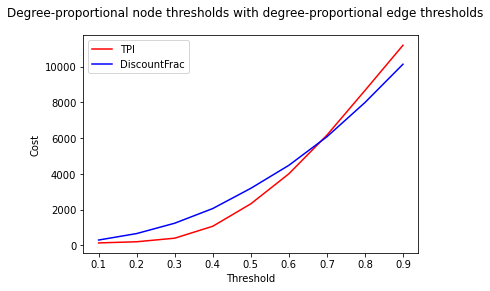

In [9]:
thresholds = numpy.linspace(PROPORTIONAL_THRESHOLD_MIN, PROPORTIONAL_THRESHOLD_MAX, PROPORTIONAL_THRESHOLD_COUNT)
tpi = numpy.zeros(PROPORTIONAL_THRESHOLD_COUNT)
discount = numpy.zeros(PROPORTIONAL_THRESHOLD_COUNT)
index = 0

for threshold in thresholds:
    # Track the sum for each threshold
    tpi_total = 0
    discount_total = 0

    for i in range(SAMPLES):
        # Define the file name for the current combination
        name = f"{DATASET} {N_MARKER_PROPORTIONAL}{threshold} {E_MARKER_PROPORTIONAL}{i}"

        # Load incentives
        tpi_incentives = data_manager.load_incentives(f"{name}.tpi.incentives")
        discount_incentives = data_manager.load_incentives(f"{name}.discount.incentives")

        # Compute the total for each algorithm
        tpi_total += sum(tpi_incentives.values())
        discount_total += sum(discount_incentives.values())

    # Compute the average
    tpi[index] = tpi_total / SAMPLES
    discount[index] = discount_total / SAMPLES

    index += 1

# Plot the results
figure, axes = pyplot.subplots()

figure.suptitle("Degree-proportional node thresholds with degree-proportional edge thresholds")
axes.set_xlabel("Threshold")
axes.set_ylabel("Cost")

axes.plot(thresholds, tpi, "r", label="TPI")
axes.plot(thresholds, discount, "b", label="DiscountFrac")

axes.legend(loc="upper left")

pyplot.show()

Here a different result is output: again the performances of the two algorithms are comparable, TPI outperforms
DiscountFrac for low fractions while the opposite happens for higher ones.

As already reported by the authors of TPI, the delta between the two algorithms is bigger for central fractions.

Overall the costs are much higher than the previous experiments and this is due to the high average degree of the
dataset that leads to the generation of higher thresholds for nodes.

### Degree-proportional node thresholds with random edge thresholds

In this the case node thresholds are set as proportional to the degree while edges activation thresholds are chosen
randomly between 0 and 1.

In [10]:
for threshold in numpy.linspace(PROPORTIONAL_THRESHOLD_MIN, PROPORTIONAL_THRESHOLD_MAX, PROPORTIONAL_THRESHOLD_COUNT):
    for i in range(SAMPLES):
        # Define the file name for the current combination
        name = f"{DATASET} {N_MARKER_PROPORTIONAL}{threshold} {E_MARKER_RANDOM}{i}"

        # Compute nodes and edges thresholds
        node_thresholds = nodes_manager.degree_proportional_thresholds(graph, threshold)
        edge_thresholds = edges_manager.random_thresholds(graph, i)

        # Prune edges
        probabilistic = edge_pruner.random_prune(graph, edge_thresholds, i)

        # Dump the graph generated and its thresholds
        data_manager.store_graph(probabilistic, f"{name}.graph")
        data_manager.store_node_thresholds(node_thresholds, f"{name}.node.thresholds")

        # Compute incentive assignment for each node
        tpi_incentives = partial_incentives.tpi(probabilistic, node_thresholds)
        data_manager.store_incentives(tpi_incentives, f"{name}.tpi.incentives")

        discount_frac_incentives = partial_incentives.discount_frac(probabilistic, node_thresholds, MAX_BUDGET)
        data_manager.store_incentives(discount_frac_incentives, f"{name}.discount.incentives")

As always the files are saved and it's possible to see the results by plotting the average cost obtained for the 10
different ways the edges of the original graph have been pruned when applying the deferred decision principle.

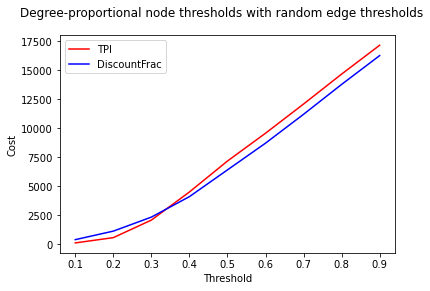

In [11]:
thresholds = numpy.linspace(PROPORTIONAL_THRESHOLD_MIN, PROPORTIONAL_THRESHOLD_MAX, PROPORTIONAL_THRESHOLD_COUNT)
tpi = numpy.zeros(PROPORTIONAL_THRESHOLD_COUNT)
discount = numpy.zeros(PROPORTIONAL_THRESHOLD_COUNT)
index = 0

for threshold in thresholds:
    # Track the sum for each threshold
    tpi_total = 0
    discount_total = 0

    for i in range(SAMPLES):
        # Define the file name for the current combination
        name = f"{DATASET} {N_MARKER_PROPORTIONAL}{threshold} {E_MARKER_RANDOM}{i}"

        # Load incentives
        tpi_incentives = data_manager.load_incentives(f"{name}.tpi.incentives")
        discount_incentives = data_manager.load_incentives(f"{name}.discount.incentives")

        # Compute the total for each algorithm
        tpi_total += sum(tpi_incentives.values())
        discount_total += sum(discount_incentives.values())

    # Compute the average
    tpi[index] = tpi_total / SAMPLES
    discount[index] = discount_total / SAMPLES

    index += 1

# Plot the results
figure, axes = pyplot.subplots()

figure.suptitle("Degree-proportional node thresholds with random edge thresholds")
axes.set_xlabel("Threshold")
axes.set_ylabel("Cost")

axes.plot(thresholds, tpi, "r", label="TPI")
axes.plot(thresholds, discount, "b", label="DiscountFrac")

axes.legend(loc="upper left")

pyplot.show()

This time the difference between the two algorithms seems smaller, but the costs are higher overall. As in the previous
case, TPI performs better for lower fractions but here the crossing point is moved to the left by a couple of tenths.

### Random node thresholds with degree-proportional edge thresholds

The case where node thresholds are set randomly (generated uniformly for each node in the range that goes from 1 to its
degree) and edge thresholds are set proportionally to the node degree is considered here.

In [12]:
for i in range(SAMPLES):
    # Define the file name for the current combination
    name = f"{DATASET} {N_MARKER_RANDOM}{i} {E_MARKER_PROPORTIONAL}{i}"

    # Compute nodes and edges thresholds
    node_thresholds = nodes_manager.random_thresholds(graph, i)
    edge_thresholds = edges_manager.degree_proportional_thresholds(graph)

    # Prune edges
    probabilistic = edge_pruner.random_prune(graph, edge_thresholds, i)

    # Dump the graph generated and its thresholds
    data_manager.store_graph(probabilistic, f"{name}.graph")
    data_manager.store_node_thresholds(node_thresholds, f"{name}.node.thresholds")

    # Compute incentive assignment for each node
    tpi_incentives = partial_incentives.tpi(probabilistic, node_thresholds)
    data_manager.store_incentives(tpi_incentives, f"{name}.tpi.incentives")

    discount_frac_incentives = partial_incentives.discount_frac(probabilistic, node_thresholds, MAX_BUDGET)
    data_manager.store_incentives(discount_frac_incentives, f"{name}.discount.incentives")

Here only 10 test cases are generated and the actual values of interest are 2, so no plotting is needed but a few
arithmetic operations to compute the mean.

In [13]:
# Track the sum for each threshold
tpi_total = 0
discount_total = 0

for i in range(SAMPLES):
    # Define the file name for the current combination
    name = f"{DATASET} {N_MARKER_RANDOM}{i} {E_MARKER_PROPORTIONAL}{i}"

    # Load incentives
    tpi_incentives = data_manager.load_incentives(f"{name}.tpi.incentives")
    discount_incentives = data_manager.load_incentives(f"{name}.discount.incentives")

    # Compute the total for each algorithm
    tpi_total += sum(tpi_incentives.values())
    discount_total += sum(discount_incentives.values())

# Compute the average
tpi_average = tpi_total / SAMPLES
discount_average = discount_total / SAMPLES

print("Random node thresholds with degree-proportional edge thresholds")
print("TPI average:", tpi_average)
print("DiscountFrac average:", discount_average)

Random node thresholds with proportional edge thresholds
TPI average: 13519.4
DiscountFrac average: 14824.7


TPI performs slightly better than DiscountFrac but once again their performances are really close.

### Random node thresholds with random edge thresholds

This is the case where both node thresholds and edges activation thresholds are chosen randomly.

In [14]:
for i in range(SAMPLES):
    # Define the file name for the current combination
    name = f"{DATASET} {N_MARKER_RANDOM}{i} {E_MARKER_RANDOM}{i}"

    # Compute nodes and edges thresholds
    node_thresholds = nodes_manager.random_thresholds(graph, i)
    edge_thresholds = edges_manager.random_thresholds(graph, i)

    # Prune edges
    probabilistic = edge_pruner.random_prune(graph, edge_thresholds, i)

    # Dump the graph generated and its thresholds
    data_manager.store_graph(probabilistic, f"{name}.graph")
    data_manager.store_node_thresholds(node_thresholds, f"{name}.node.thresholds")

    # Compute incentive assignment for each node
    tpi_incentives = partial_incentives.tpi(probabilistic, node_thresholds)
    data_manager.store_incentives(tpi_incentives, f"{name}.tpi.incentives")

    discount_frac_incentives = partial_incentives.discount_frac(probabilistic, node_thresholds, MAX_BUDGET)
    data_manager.store_incentives(discount_frac_incentives, f"{name}.discount.incentives")

Here again values of interest are just 2, the average cost of the 10 execution pairs for each algorithm.
 

In [15]:
# Track the sum for each threshold
tpi_total = 0
discount_total = 0

for i in range(SAMPLES):
    # Define the file name for the current combination
    name = f"{DATASET} {N_MARKER_RANDOM}{i} {E_MARKER_RANDOM}{i}"

    # Load incentives
    tpi_incentives = data_manager.load_incentives(f"{name}.tpi.incentives")
    discount_incentives = data_manager.load_incentives(f"{name}.discount.incentives")

    # Compute the total for each algorithm
    tpi_total += sum(tpi_incentives.values())
    discount_total += sum(discount_incentives.values())

# Compute the average
tpi_average = tpi_total / SAMPLES
discount_average = discount_total / SAMPLES

print("Random node thresholds with random edge thresholds")
print("TPI average:", tpi_average)
print("DiscountFrac average:", discount_average)

Random node thresholds with random edge thresholds
TPI average: 19417.8
DiscountFrac average: 19225.3


For one last time the performances of both TPI and DiscountFrac are very close, but here the latter slightly
outperforms the first.

# Conclusions

Overall this project shows that the algorithms picked are indeed working also for nondeterministic models when
deferred decision principle is applied. Also, the results of the experiments made here are similar to those already
reported for the deterministic version of the model.